In [1]:

#!/usr/bin/env python3
"""
Simple Qualitative Results Comparison
=====================================

Creates clean comparison between Ground Truth and interpolation methods.
- Ground Truth vs Optical Flow
- Ground Truth vs Spline  
- Ground Truth vs Linear

Uses classes from evals/baseline_evaluation.py for consistency.
"""

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
from typing import Dict, List, Optional
import torch

# Set up paths
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.append(str(project_root))

# Import evaluation classes
from src.eval.baseline_evaluation import (
    SparseInterpolationDataset,
    SparseLinearInterpolator,
    SparseSplineInterpolator,
    SparseOpticalFlowInterpolator
)


In [2]:
class Config:
    # Update these paths to match your data
    DATA_PATH = "/home/ragenius_admin/azureblob/4D-Lung-Interpolated/data"
    MANIFEST_PATH = "/home/ragenius_admin/azureblob/4D-Lung-Interpolated/manifest.csv"
    
    # Anatomical levels
    TARGET_SLICES = [12, 25, 37]  # Base, Middle, Apex
    SLICE_NAMES = {12: "Base", 25: "Middle", 37: "Apex"}
    
    # Phases to show
    PHASES_TO_SHOW = [10, 20, 30, 40]
    # CT windowing for lung tissue
    CT_WINDOW = (-600, 900)

config = Config()

In [3]:



def apply_ct_windowing(image, window=(-600, 900)):
    """Apply CT windowing"""
    windowed = np.clip(image, window[0], window[1])
    normalized = (windowed - window[0]) / (window[1] - window[0])
    return normalized

def create_error_colormap():
    """White to red colormap for errors"""
    colors = ['#FFFFFF', '#FFE0E0', '#FFC0C0', '#FF8080', '#FF4040', '#FF0000', '#CC0000']
    return LinearSegmentedColormap.from_list('error_cmap', colors, N=256)

def load_sample_for_slice(dataset, slice_num, patient_id=None, sample_idx=None):
    """
    Load sample for slice with optional patient/sample selection
    
    Args:
        dataset: SparseInterpolationDataset
        slice_num: Target slice number (12, 25, 37)
        patient_id: Optional specific patient ID to use
        sample_idx: Optional specific sample index to use
    
    Returns:
        Sample data dict or None
    """
    candidates = []
    
    # Collect all valid samples for this slice
    for i in range(len(dataset)):
        try:
            sample = dataset[i]
            if sample['slice_num'] == slice_num:
                candidates.append((i, sample))
        except:
            continue
    
    if not candidates:
        print(f"No samples found for slice {slice_num}")
        return None
    
    print(f"Found {len(candidates)} samples for slice {slice_num}")
    
    # Print available samples info
    print("Available samples:")
    for idx, (i, sample) in enumerate(candidates[:5]):  # Show first 5
        sample_id = sample.get('sample_id', f'sample_{i}')
        print(f"  [{idx}] {sample_id}")
    
    # Selection logic
    if patient_id:
        # Find sample with specific patient_id
        for i, sample in candidates:
            if patient_id in sample.get('sample_id', ''):
                print(f"Using patient {patient_id}: {sample.get('sample_id')}")
                return sample
        print(f"Patient {patient_id} not found, using first available")
    
    if sample_idx is not None and 0 <= sample_idx < len(candidates):
        # Use specific sample index
        i, sample = candidates[sample_idx]
        print(f"Using sample [{sample_idx}]: {sample.get('sample_id')}")
        return sample
    
    # Default: use first available
    i, sample = candidates[0]
    print(f"Using first available: {sample.get('sample_id')}")
    return sample

def browse_dataset_samples(dataset, slice_num=None):
    """
    Browse available samples in the dataset
    
    Args:
        dataset: SparseInterpolationDataset
        slice_num: Optional slice to filter by
    """
    print("Dataset Sample Browser")
    print("=" * 50)
    
    samples_info = []
    for i in range(min(len(dataset), 50)):  # Limit to first 50 for browsing
        try:
            sample = dataset[i]
            
            if slice_num is None or sample['slice_num'] == slice_num:
                sample_info = {
                    'index': i,
                    'sample_id': sample.get('sample_id', f'sample_{i}'),
                    'slice_num': sample['slice_num'],
                    'metadata': sample.get('metadata', {})
                }
                samples_info.append(sample_info)
        except:
            continue
    
    # Group by slice for better display
    if slice_num is None:
        slices = sorted(set(info['slice_num'] for info in samples_info))
        for s in slices:
            slice_samples = [info for info in samples_info if info['slice_num'] == s]
            print(f"\nSlice {s}: {len(slice_samples)} samples")
            for info in slice_samples[:3]:  # Show first 3 per slice
                print(f"  [{info['index']}] {info['sample_id']}")
    else:
        print(f"\nSlice {slice_num}: {len(samples_info)} samples")
        for info in samples_info:
            print(f"  [{info['index']}] {info['sample_id']}")
    
    return samples_info

In [ ]:
# # ===============================================
# # CELL 1: PARALLEL LINEAR INTERPOLATION WITH NORMALIZED ERROR
# # ===============================================

# import numpy as np
# import pickle
# from pathlib import Path
# from concurrent.futures import ProcessPoolExecutor, as_completed
# import multiprocessing as mp
# import time

# # Load dataset WITH SAMPLE LIMIT
# dataset = SparseInterpolationDataset(
#     config.MANIFEST_PATH,
#     config.DATA_PATH,
#     split='test',
#     target_slices=config.TARGET_SLICES
# )

# # LIMIT DATASET SIZE to speed up processing
# print(f"📊 Original dataset size: {len(dataset)} samples")
# if len(dataset) > 50:
#     # Limit to first 50 samples to speed up processing
#     dataset.df = dataset.df.head(50)
#     print(f"🚀 Limited to first 50 samples for faster processing")
# else:
#     print(f"📊 Using all {len(dataset)} samples")

# # Create metrics calculation functions
# def calculate_psnr(img1, img2, data_range=1.0):
#     """Calculate PSNR between two images"""
#     mse = np.mean((img1 - img2) ** 2)
#     if mse == 0:
#         return float('inf')
#     return 20 * np.log10(data_range / np.sqrt(mse))

# def calculate_ssim_simple(img1, img2):
#     """Simple SSIM calculation (approximation)"""
#     img1_flat = img1.flatten()
#     img2_flat = img2.flatten()
    
#     mu1 = np.mean(img1_flat)
#     mu2 = np.mean(img2_flat)
#     var1 = np.var(img1_flat)
#     var2 = np.var(img2_flat)
#     cov = np.mean((img1_flat - mu1) * (img2_flat - mu2))
    
#     c1 = 0.01 ** 2
#     c2 = 0.03 ** 2
    
#     ssim = ((2 * mu1 * mu2 + c1) * (2 * cov + c2)) / ((mu1**2 + mu2**2 + c1) * (var1 + var2 + c2))
#     return max(0, min(1, ssim))

# def apply_ct_windowing_parallel(image, window=(-600, 900)):
#     """Apply CT windowing (parallel-safe version)"""
#     windowed = np.clip(image, window[0], window[1])
#     normalized = (windowed - window[0]) / (window[1] - window[0])
#     return normalized

# def process_single_phase(args):
#     """
#     Process a single phase with NORMALIZED ERROR - designed for parallel execution
    
#     Args:
#         args: tuple of (phase, gt_frame, linear_frame, ct_window)
    
#     Returns:
#         dict with all processed data for this phase
#     """
#     phase, gt_frame, linear_frame, ct_window = args
    
#     try:
#         # Apply windowing (normalize to 0-1 range)
#         gt_windowed = apply_ct_windowing_parallel(gt_frame, ct_window)
#         linear_windowed = apply_ct_windowing_parallel(linear_frame, ct_window)
        
#         # Calculate NORMALIZED error (0-1 range) - consistent with metrics
#         lung_mask = gt_windowed > 0.1
#         normalized_error = np.abs(linear_windowed - gt_windowed) * lung_mask
        
#         # Calculate METRICS (same normalization as error)
#         if np.any(lung_mask):
#             # PSNR on normalized images (consistent with error visualization)
#             psnr_value = calculate_psnr(linear_windowed, gt_windowed, data_range=1.0)
            
#             # SSIM on normalized images
#             ssim_value = calculate_ssim_simple(linear_windowed, gt_windowed)
            
#             # Error statistics on normalized scale
#             error_max = max(np.percentile(normalized_error[lung_mask], 95), 0.05)  # 0-1 range
#             mean_error = np.mean(normalized_error[lung_mask])
#         else:
#             psnr_value = 0
#             ssim_value = 0
#             error_max = 0.2  # Default for 0-1 range
#             mean_error = 0
        
#         return {
#             'phase': phase,
#             'gt_windowed': gt_windowed,
#             'linear_windowed': linear_windowed,
#             'normalized_error': normalized_error,  # NEW: 0-1 range error
#             'error_max': error_max,
#             'lung_mask': lung_mask,
#             'psnr': psnr_value,
#             'ssim': ssim_value,
#             'mean_error': mean_error,  # Now in 0-1 range
#             'success': True
#         }
        
#     except Exception as e:
#         return {
#             'phase': phase,
#             'error': str(e),
#             'success': False
#         }

# print("="*60)
# print("PARALLEL PROCESSING WITH NORMALIZED ERROR")
# print("="*60)

# # Check CPU cores
# n_cores = mp.cpu_count()
# n_workers = min(6, n_cores)
# print(f"💻 Available CPU cores: {n_cores}")
# print(f"🚀 Using {n_workers} parallel workers")
# print(f"📊 Dataset loaded: {len(dataset)} samples")

# start_time = time.time()

# # Initialize linear interpolator
# linear_interpolator = SparseLinearInterpolator()

# # Process only the first slice (Base level, slice 12)
# slice_num = 12
# slice_name = config.SLICE_NAMES[slice_num]

# print(f"Processing {slice_name} (Slice {slice_num})...")

# # Load sample for base level
# sample = load_sample_for_slice(dataset, slice_num)

# if sample is None:
#     print(f"❌ No sample found for slice {slice_num}")
#     raise Exception(f"Cannot find sample for slice {slice_num}")

# # Get input phases
# phase_0 = sample['input_phases']['phase_0'].cpu().numpy()
# phase_50 = sample['input_phases']['phase_50'].cpu().numpy()

# print(f"Input phase shapes: {phase_0.shape}, {phase_50.shape}")

# # Generate linear interpolation for all phases
# print("Running linear interpolation...")
# linear_results = linear_interpolator.interpolate(phase_0, phase_50)

# print(f"Generated phases: {list(linear_results.keys())}")

# # Prepare data for parallel processing
# phases_to_show = [10, 20, 30, 40]
# ct_window = config.CT_WINDOW

# # Create arguments for parallel processing
# parallel_args = []
# for phase in phases_to_show:
#     phase_key = f'phase_{phase}'
#     gt_frame = sample['ground_truth_phases'][phase_key].cpu().numpy()
#     linear_frame = linear_results[phase_key]
    
#     parallel_args.append((phase, gt_frame, linear_frame, ct_window))

# print(f"🔄 Processing {len(parallel_args)} phases in parallel with normalized error...")

# # Process all phases in parallel
# visualization_data = {}
# failed_phases = []

# with ProcessPoolExecutor(max_workers=n_workers) as executor:
#     # Submit all tasks
#     future_to_phase = {executor.submit(process_single_phase, args): args[0] 
#                       for args in parallel_args}
    
#     # Collect results as they complete
#     for future in as_completed(future_to_phase):
#         phase = future_to_phase[future]
#         try:
#             result = future.result()
#             if result['success']:
#                 visualization_data[result['phase']] = result
#                 print(f"✅ Phase {phase}%: PSNR={result['psnr']:.2f}, SSIM={result['ssim']:.3f}, Norm Error={result['mean_error']:.3f}")
#             else:
#                 failed_phases.append(phase)
#                 print(f"❌ Phase {phase}% failed: {result['error']}")
#         except Exception as e:
#             failed_phases.append(phase)
#             print(f"❌ Phase {phase}% failed with exception: {e}")

# if failed_phases:
#     print(f"⚠️  Failed phases: {failed_phases}")

# processing_time = time.time() - start_time
# print(f"⏱️  Parallel processing completed in {processing_time:.2f} seconds")

# # Prepare arrays for persistence
# gt_images = []
# linear_images = []
# normalized_error_maps = []  # NEW: normalized error maps
# metrics_data = []

# for phase in sorted(phases_to_show):
#     if phase in visualization_data:
#         data = visualization_data[phase]
#         gt_images.append(data['gt_windowed'])
#         linear_images.append(data['linear_windowed'])
#         normalized_error_maps.append(data['normalized_error'])  # 0-1 range errors
#         metrics_data.append({
#             'phase': phase,
#             'psnr': data['psnr'],
#             'ssim': data['ssim'],
#             'error_max': data['error_max'],
#             'mean_error': data['mean_error']  # Now normalized 0-1
#         })

# # Save data persistently
# output_dir = Path('outputs')
# output_dir.mkdir(exist_ok=True)

# print("💾 Saving processed data with normalized errors...")

# # Save as numpy arrays
# np.save(output_dir / 'gt_images.npy', np.array(gt_images))
# np.save(output_dir / 'linear_images.npy', np.array(linear_images))
# np.save(output_dir / 'normalized_error_maps.npy', np.array(normalized_error_maps))  # NEW

# # Save metrics and other data as pickle
# with open(output_dir / 'visualization_data.pkl', 'wb') as f:
#     pickle.dump(visualization_data, f)

# with open(output_dir / 'metrics_data.pkl', 'wb') as f:
#     pickle.dump(metrics_data, f)

# # Save processing info
# processing_info = {
#     'n_workers': n_workers,
#     'processing_time': processing_time,
#     'failed_phases': failed_phases,
#     'n_cores_available': n_cores,
#     'error_type': 'normalized_0_1_range'  # NEW: document error type
# }

# with open(output_dir / 'processing_info.pkl', 'wb') as f:
#     pickle.dump(processing_info, f)

# print("✅ Parallel processing with normalized error completed!")
# print("📁 Data saved persistently:")
# print(f"   - gt_images.npy, linear_images.npy, normalized_error_maps.npy")
# print(f"   - visualization_data.pkl, metrics_data.pkl, processing_info.pkl")
# print(f"🚀 Used {n_workers} workers, completed in {processing_time:.2f}s")

# # Print metrics summary
# print("\n=== NORMALIZED ERROR METRICS SUMMARY ===")
# print("Phase    PSNR    SSIM    Norm Error")
# print("-" * 40)
# for data in sorted(metrics_data, key=lambda x: x['phase']):
#     status = "✅ Success" if data['phase'] not in failed_phases else "❌ Failed"
#     print(f"{data['phase']:2d}%    {data['psnr']:5.2f}   {data['ssim']:.3f}   {data['mean_error']:.3f}   {status}")

# print(f"\n💡 Normalized Error Interpretation:")
# print(f"   • 0.000: Perfect match (identical intensities)")
# print(f"   • 0.050: Small differences (~5% intensity variation)")
# print(f"   • 0.100: Moderate differences (~10% intensity variation)")
# print(f"   • 0.200+: Large differences (significant interpolation errors)")
# print(f"\n✅ Error maps now directly consistent with PSNR/SSIM calculations!")
# print("✅ Ready for visualization in next cell")

In [37]:
# ===============================================
# CELL 1: PARALLEL OPTICAL FLOW INTERPOLATION WITH NORMALIZED ERROR
# ===============================================

import numpy as np
import pickle
from pathlib import Path
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
import time
import cv2
import logging

# Load dataset WITH SAMPLE LIMIT
dataset = SparseInterpolationDataset(
    config.MANIFEST_PATH,
    config.DATA_PATH,
    split='test',
    target_slices=config.TARGET_SLICES
)

# LIMIT DATASET SIZE to speed up processing
print(f"📊 Original dataset size: {len(dataset)} samples")
if len(dataset) > 50:
    # Limit to first 50 samples to speed up processing
    dataset.df = dataset.df.head(50)
    print(f"🚀 Limited to first 50 samples for faster processing")
else:
    print(f"📊 Using all {len(dataset)} samples")

# Create metrics calculation functions
def calculate_psnr(img1, img2, data_range=1.0):
    """Calculate PSNR between two images"""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(data_range / np.sqrt(mse))

def calculate_ssim_simple(img1, img2):
    """Simple SSIM calculation (approximation)"""
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    
    mu1 = np.mean(img1_flat)
    mu2 = np.mean(img2_flat)
    var1 = np.var(img1_flat)
    var2 = np.var(img2_flat)
    cov = np.mean((img1_flat - mu1) * (img2_flat - mu2))
    
    c1 = 0.01 ** 2
    c2 = 0.03 ** 2
    
    ssim = ((2 * mu1 * mu2 + c1) * (2 * cov + c2)) / ((mu1**2 + mu2**2 + c1) * (var1 + var2 + c2))
    return max(0, min(1, ssim))

def apply_ct_windowing_parallel(image, window=(-600, 900)):
    """Apply CT windowing (parallel-safe version)"""
    windowed = np.clip(image, window[0], window[1])
    normalized = (windowed - window[0]) / (window[1] - window[0])
    return normalized

def optical_flow_interpolation(frame1, frame2, target_phase, start_phase=0, end_phase=50):
    """
    Optical flow guided interpolation between two frames
    """
    try:
        # Normalize frames consistently for optical flow
        def normalize_frames_consistently(f1, f2):
            f1 = np.asarray(f1, dtype=np.float64)
            f2 = np.asarray(f2, dtype=np.float64)
            
            # Use global min/max for consistent normalization
            global_min = min(np.min(f1), np.min(f2))
            global_max = max(np.max(f1), np.max(f2))
            
            if global_max > global_min:
                f1_norm = ((f1 - global_min) / (global_max - global_min) * 255).astype(np.uint8)
                f2_norm = ((f2 - global_min) / (global_max - global_min) * 255).astype(np.uint8)
            else:
                f1_norm = np.zeros_like(f1, dtype=np.uint8)
                f2_norm = np.zeros_like(f2, dtype=np.uint8)
            
            return f1_norm, f2_norm, global_min, global_max
        
        frame1_uint8, frame2_uint8, global_min, global_max = normalize_frames_consistently(frame1, frame2)
        
        # Calculate optical flow using Farneback algorithm
        flow = cv2.calcOpticalFlowFarneback(
            frame1_uint8, frame2_uint8, None,
            pyr_scale=0.5, levels=3, winsize=15,
            iterations=3, poly_n=5, poly_sigma=1.2, flags=0
        )
        
        # Check if optical flow succeeded
        if flow is None or np.any(np.isnan(flow)) or np.any(np.isinf(flow)):
            # Fall back to linear interpolation
            alpha = (target_phase - start_phase) / (end_phase - start_phase)
            return (1 - alpha) * frame1 + alpha * frame2
        
        # Interpolation factor
        alpha = (target_phase - start_phase) / (end_phase - start_phase)
        
        # Apply weighted flow
        h, w = frame1.shape
        flow_scaled = flow * alpha
        
        # Create mesh grid
        row_coords, col_coords = np.meshgrid(np.arange(h), np.arange(w), indexing='ij')
        
        # Apply flow displacement
        displaced_rows = row_coords + flow_scaled[..., 1]
        displaced_cols = col_coords + flow_scaled[..., 0]
        
        # Remap the image
        interpolated_uint8 = cv2.remap(
            frame1_uint8.astype(np.float32),
            displaced_cols.astype(np.float32),
            displaced_rows.astype(np.float32),
            cv2.INTER_LINEAR,
            borderMode=cv2.BORDER_REFLECT
        )
        
        # Convert back to original scale
        if global_max > global_min:
            interpolated = interpolated_uint8 / 255.0 * (global_max - global_min) + global_min
        else:
            interpolated = frame1.copy()  # If no range, return original
        
        interpolated = np.clip(interpolated, global_min, global_max)
        
        return interpolated
        
    except Exception as e:
        logging.warning(f"Optical flow failed: {e}. Using linear interpolation.")
        # Fall back to linear interpolation
        alpha = (target_phase - start_phase) / (end_phase - start_phase)
        return (1 - alpha) * frame1 + alpha * frame2

def process_single_phase_optical_flow(args):
    """
    Process a single phase with OPTICAL FLOW - designed for parallel execution
    
    Args:
        args: tuple of (phase, gt_frame, phase_0_frame, phase_50_frame, ct_window)
    
    Returns:
        dict with all processed data for this phase
    """
    phase, gt_frame, phase_0_frame, phase_50_frame, ct_window = args
    
    try:
        # Apply windowing (normalize to 0-1 range)
        gt_windowed = apply_ct_windowing_parallel(gt_frame, ct_window)
        phase_0_windowed = apply_ct_windowing_parallel(phase_0_frame, ct_window)
        phase_50_windowed = apply_ct_windowing_parallel(phase_50_frame, ct_window)
        
        # Generate optical flow interpolated frame
        optical_flow_frame = optical_flow_interpolation(
            phase_0_windowed, phase_50_windowed, phase, 
            start_phase=0, end_phase=50
        )
        
        # Calculate NORMALIZED error (0-1 range) - consistent with metrics
        lung_mask = gt_windowed > 0.1
        normalized_error = np.abs(optical_flow_frame - gt_windowed) * lung_mask
        
        # Calculate METRICS (same normalization as error)
        if np.any(lung_mask):
            # PSNR on normalized images (consistent with error visualization)
            psnr_value = calculate_psnr(optical_flow_frame, gt_windowed, data_range=1.0)
            
            # SSIM on normalized images
            ssim_value = calculate_ssim_simple(optical_flow_frame, gt_windowed)
            
            # Error statistics on normalized scale
            error_max = max(np.percentile(normalized_error[lung_mask], 95), 0.05)  # 0-1 range
            mean_error = np.mean(normalized_error[lung_mask])
        else:
            psnr_value = 0
            ssim_value = 0
            error_max = 0.2  # Default for 0-1 range
            mean_error = 0
        
        return {
            'phase': phase,
            'gt_windowed': gt_windowed,
            'optical_flow_windowed': optical_flow_frame,
            'normalized_error': normalized_error,  # NEW: 0-1 range error
            'error_max': error_max,
            'lung_mask': lung_mask,
            'psnr': psnr_value,
            'ssim': ssim_value,
            'mean_error': mean_error,  # Now in 0-1 range
            'success': True
        }
        
    except Exception as e:
        return {
            'phase': phase,
            'error': str(e),
            'success': False
        }

print("="*60)
print("PARALLEL OPTICAL FLOW PROCESSING WITH NORMALIZED ERROR")
print("="*60)

# Check CPU cores
n_cores = mp.cpu_count()
n_workers = min(6, n_cores)
print(f"💻 Available CPU cores: {n_cores}")
print(f"🚀 Using {n_workers} parallel workers")
print(f"📊 Dataset loaded: {len(dataset)} samples")

start_time = time.time()

# Process only the first slice (Base level, slice 12)
slice_num = 12
slice_name = config.SLICE_NAMES[slice_num]

print(f"Processing {slice_name} (Slice {slice_num}) with Optical Flow...")

# Load sample for base level
sample = load_sample_for_slice(dataset, slice_num)

if sample is None:
    print(f"❌ No sample found for slice {slice_num}")
    raise Exception(f"Cannot find sample for slice {slice_num}")

# Get input phases (0% and 50% for optical flow)
phase_0 = sample['input_phases']['phase_0'].cpu().numpy()
phase_50 = sample['input_phases']['phase_50'].cpu().numpy()

print(f"Input phase shapes: {phase_0.shape}, {phase_50.shape}")

# Prepare data for parallel processing
phases_to_show = [10, 20, 30, 40]
ct_window = config.CT_WINDOW

# Create arguments for parallel processing
parallel_args = []
for phase in phases_to_show:
    phase_key = f'phase_{phase}'
    gt_frame = sample['ground_truth_phases'][phase_key].cpu().numpy()
    
    parallel_args.append((phase, gt_frame, phase_0, phase_50, ct_window))

print(f"🔄 Processing {len(parallel_args)} phases in parallel with OPTICAL FLOW...")

# Process all phases in parallel
visualization_data = {}
failed_phases = []

with ProcessPoolExecutor(max_workers=n_workers) as executor:
    # Submit all tasks
    future_to_phase = {executor.submit(process_single_phase_optical_flow, args): args[0] 
                      for args in parallel_args}
    
    # Collect results as they complete
    for future in as_completed(future_to_phase):
        phase = future_to_phase[future]
        try:
            result = future.result()
            if result['success']:
                visualization_data[result['phase']] = result
                print(f"✅ Phase {phase}%: PSNR={result['psnr']:.2f}, SSIM={result['ssim']:.3f}, Norm Error={result['mean_error']:.3f}")
            else:
                failed_phases.append(phase)
                print(f"❌ Phase {phase}% failed: {result['error']}")
        except Exception as e:
            failed_phases.append(phase)
            print(f"❌ Phase {phase}% failed with exception: {e}")

if failed_phases:
    print(f"⚠️  Failed phases: {failed_phases}")

processing_time = time.time() - start_time
print(f"⏱️  Parallel optical flow processing completed in {processing_time:.2f} seconds")

# Prepare arrays for persistence
gt_images = []
optical_flow_images = []
normalized_error_maps = []  # NEW: normalized error maps
metrics_data = []

for phase in sorted(phases_to_show):
    if phase in visualization_data:
        data = visualization_data[phase]
        gt_images.append(data['gt_windowed'])
        optical_flow_images.append(data['optical_flow_windowed'])
        normalized_error_maps.append(data['normalized_error'])  # 0-1 range errors
        metrics_data.append({
            'phase': phase,
            'psnr': data['psnr'],
            'ssim': data['ssim'],
            'error_max': data['error_max'],
            'mean_error': data['mean_error']  # Now normalized 0-1
        })

# Save data persistently
output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)

print("💾 Saving processed optical flow data with normalized errors...")

# Save as numpy arrays
np.save(output_dir / 'gt_images.npy', np.array(gt_images))
np.save(output_dir / 'optical_flow_images.npy', np.array(optical_flow_images))  # Changed from linear_images
np.save(output_dir / 'normalized_error_maps.npy', np.array(normalized_error_maps))  # NEW

# Save metrics and other data as pickle
with open(output_dir / 'visualization_data.pkl', 'wb') as f:
    pickle.dump(visualization_data, f)

with open(output_dir / 'metrics_data.pkl', 'wb') as f:
    pickle.dump(metrics_data, f)

# Save processing info
processing_info = {
    'method': 'optical_flow',  # Changed from linear
    'n_workers': n_workers,
    'processing_time': processing_time,
    'failed_phases': failed_phases,
    'n_cores_available': n_cores,
    'error_type': 'normalized_0_1_range',
    'flow_algorithm': 'farneback'  # NEW: document flow algorithm
}

with open(output_dir / 'processing_info.pkl', 'wb') as f:
    pickle.dump(processing_info, f)

print("✅ Parallel optical flow processing with normalized error completed!")
print("📁 Data saved persistently:")
print(f"   - gt_images.npy, optical_flow_images.npy, normalized_error_maps.npy")
print(f"   - visualization_data.pkl, metrics_data.pkl, processing_info.pkl")
print(f"🚀 Used {n_workers} workers, completed in {processing_time:.2f}s")

# Print metrics summary
print("\n=== OPTICAL FLOW NORMALIZED ERROR METRICS SUMMARY ===")
print("Phase    PSNR    SSIM    Norm Error    Method")
print("-" * 50)
for data in sorted(metrics_data, key=lambda x: x['phase']):
    status = "✅ OF Success" if data['phase'] not in failed_phases else "❌ Failed"
    print(f"{data['phase']:2d}%    {data['psnr']:5.2f}   {data['ssim']:.3f}   {data['mean_error']:.3f}       {status}")

print(f"\n💡 Optical Flow vs Linear Comparison:")
print(f"   • Optical Flow: Motion-guided interpolation using Farneback algorithm")
print(f"   • Expected: Better anatomical structure preservation")
print(f"   • Handles: Non-linear breathing motion patterns")
print(f"\n💡 Normalized Error Interpretation:")
print(f"   • 0.000: Perfect match (identical intensities)")
print(f"   • 0.050: Small differences (~5% intensity variation)")
print(f"   • 0.100: Moderate differences (~10% intensity variation)")
print(f"   • 0.200+: Large differences (significant interpolation errors)")
print(f"\n✅ Error maps now directly consistent with PSNR/SSIM calculations!")
print("✅ Ready for optical flow visualization in next cell")

2025-08-13 20:00:13,392 - INFO - No 'split' column found. Using all 964 completed samples as test data
2025-08-13 20:00:13,394 - INFO - Filtered to target slices [12, 25, 37]: 848 samples


📊 Original dataset size: 848 samples
🚀 Limited to first 50 samples for faster processing
PARALLEL OPTICAL FLOW PROCESSING WITH NORMALIZED ERROR
💻 Available CPU cores: 6
🚀 Using 6 parallel workers
📊 Dataset loaded: 50 samples
Processing Base (Slice 12) with Optical Flow...
Found 17 samples for slice 12
Available samples:
  [0] 108_HM10395_108_HM10395_S122_0012
  [1] 109_HM10395_109_HM10395_S122_0012
  [2] 109_HM10395_109_HM10395_S101_0012
  [3] 109_HM10395_109_HM10395_S118_0012
  [4] 109_HM10395_109_HM10395_S124_0012
Using first available: 108_HM10395_108_HM10395_S122_0012
Input phase shapes: (512, 512), (512, 512)
🔄 Processing 4 phases in parallel with OPTICAL FLOW...
✅ Phase 30%: PSNR=23.42, SSIM=0.926, Norm Error=0.101
✅ Phase 10%: PSNR=27.49, SSIM=0.971, Norm Error=0.065
✅ Phase 20%: PSNR=24.55, SSIM=0.943, Norm Error=0.091
✅ Phase 40%: PSNR=22.87, SSIM=0.916, Norm Error=0.106
⏱️  Parallel optical flow processing completed in 32.19 seconds
💾 Saving processed optical flow data with n

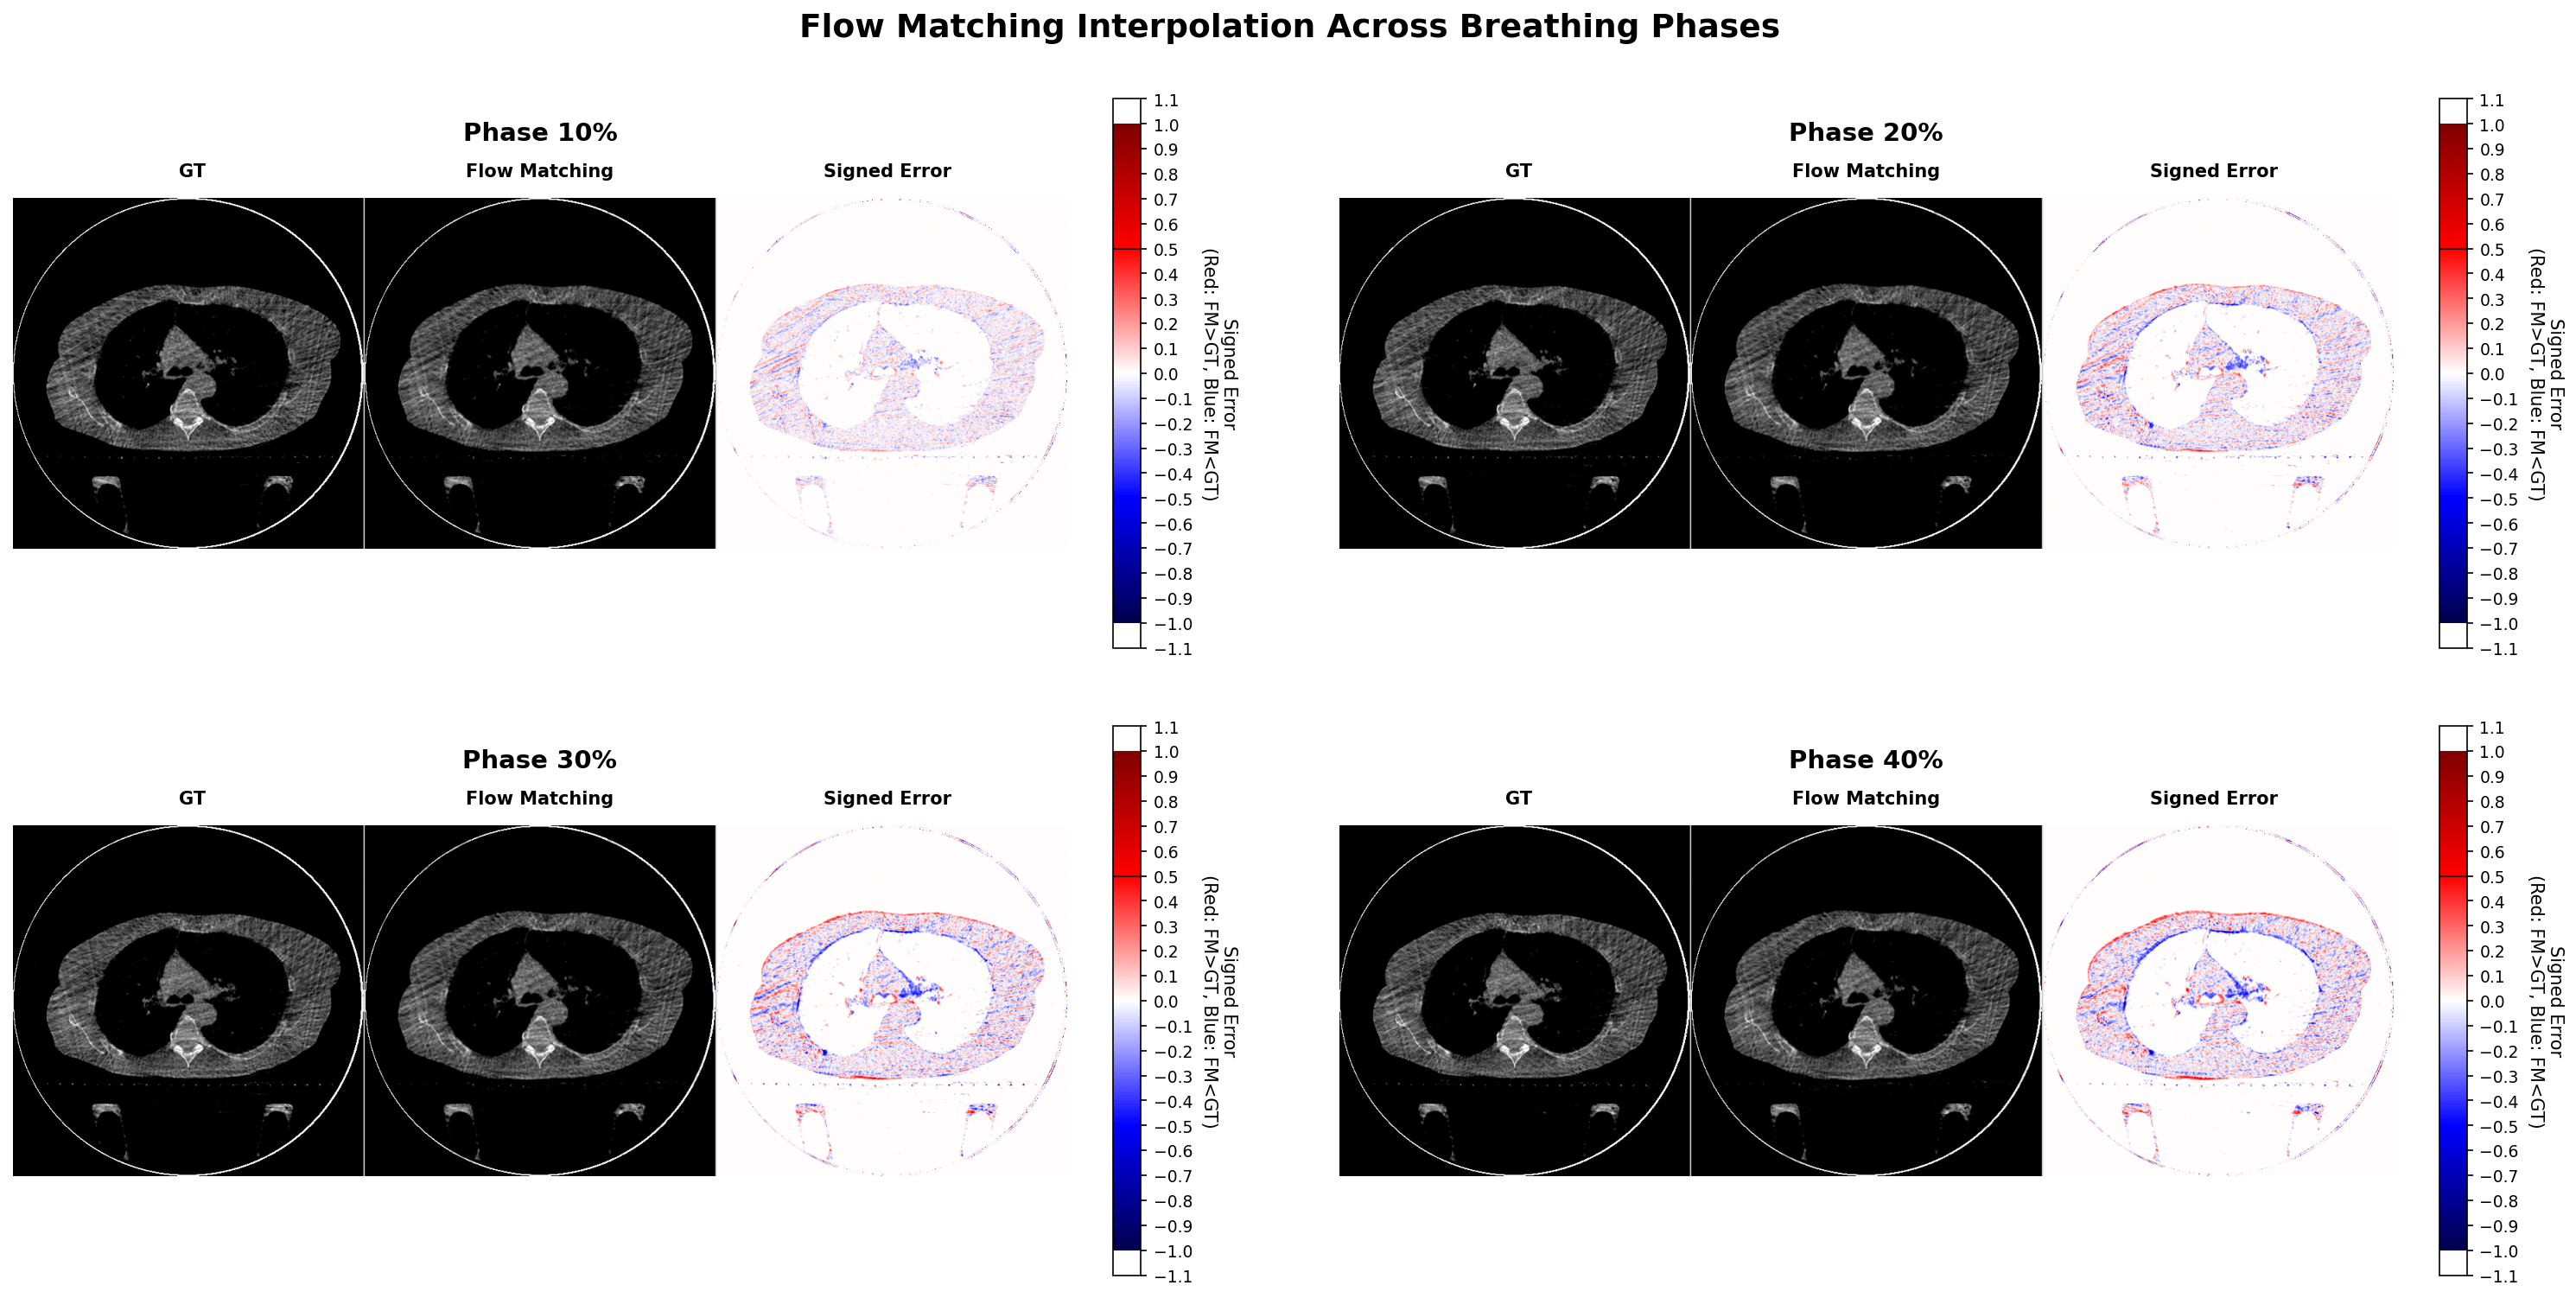

✅ Signed Error Visualization Updates:
🔴 Red regions: Flow Matching predicts HIGHER intensity than Ground Truth
🔵 Blue regions: Flow Matching predicts LOWER intensity than Ground Truth
⚫ Black line on colorbar: Zero difference (perfect match)
📊 Symmetric scale: Equal range for positive and negative errors
📈 Global error range: ±1.000


In [ ]:
import pickle

# Load persistent data
output_dir = Path('outputs')

# Load data from files
gt_images = np.load(output_dir / 'gt_images.npy')
linear_images = np.load(output_dir / 'optical_flow_images.npy') 
normalized_error_maps = np.load(output_dir / 'normalized_error_maps.npy')  # NEW: 0-1 range

with open(output_dir / 'visualization_data.pkl', 'rb') as f:
    visualization_data = pickle.load(f)
    
with open(output_dir / 'metrics_data.pkl', 'rb') as f:
    metrics_data = pickle.load(f)


def setup_plotting():
    """Clean matplotlib setup"""
    plt.rcParams.update({
        'font.size': 10,
        'axes.titlesize': 11,
        'figure.facecolor': 'white',
        'axes.grid': False,
        'axes.spines.top': False,
        'axes.spines.right': False,
        'axes.spines.left': False,
        'axes.spines.bottom': False,
        'xtick.bottom': False,
        'ytick.left': False,
    })

# ===============================================
# SIGNED ERROR VERSION: RED=POSITIVE, BLUE=NEGATIVE
# ===============================================

def create_horizontal_composite_signed(gt_img, pred_img, signed_error, max_abs_error, error_cmap):
    """Enhanced version with signed error visualization"""
    h, w = gt_img.shape
    
    # Normalize signed error to [-1, 1] range for colormap
    if max_abs_error > 0:
        error_normalized = signed_error / max_abs_error
    else:
        error_normalized = signed_error
    
    # Apply diverging colormap (centered at 0)
    # Need to map [-1,1] to [0,1] for colormap: (x + 1) / 2
    error_for_cmap = (error_normalized + 1) / 2
    error_rgb = plt.cm.get_cmap(error_cmap)(error_for_cmap)[:, :, :3]
    
    # Convert grayscale to RGB
    gt_rgb = np.stack([gt_img] * 3, axis=2)
    pred_rgb = np.stack([pred_img] * 3, axis=2)
    
    # Add thin separators
    separator = np.ones((h, 2, 3)) * 0.8  # Light gray separators
    
    # Concatenate
    composite = np.concatenate([gt_rgb, separator, pred_rgb, separator, error_rgb], axis=1)
    
    return composite

# Setup plotting
setup_plotting()
error_cmap = 'seismic'  # Red=positive (Flow Matching > GT), Blue=negative (Flow Matching < GT)

# Create figure with better spacing
fig, axes = plt.subplots(2, 2, figsize=(20, 12), dpi=150)
axes = axes.flatten()

fig.suptitle('Flow Matching Interpolation Across Breathing Phases', 
             fontsize=18, fontweight='bold', y=0.90)

phases = [10, 20, 30, 40]

# Calculate global signed error range for consistent scaling
all_signed_errors = []
for phase in phases:
    data = visualization_data[phase]
    gt_windowed = data['gt_windowed']
    linear_windowed = data['optical_flow_windowed']
    signed_error = linear_windowed - gt_windowed  # Calculate signed difference
    all_signed_errors.append(signed_error)

# Find global symmetric range
global_max_abs_error = np.max([np.max(np.abs(err)) for err in all_signed_errors])

for idx, phase in enumerate(phases):
    ax = axes[idx]
    
    # Get data
    data = visualization_data[phase]
    gt_windowed = data['gt_windowed']
    linear_windowed = data['optical_flow_windowed']
    
    # Calculate signed error: Positive = Flow Matching higher, Negative = GT higher
    signed_error = linear_windowed - gt_windowed
    
    # Create enhanced composite with signed error
    composite = create_horizontal_composite_signed(
        gt_windowed, linear_windowed, signed_error, global_max_abs_error, error_cmap)
    
    # Display composite
    ax.imshow(composite)
    
    # Main title: Phase percentage
    ax.set_title(f'Phase {phase}%', 
                fontsize=14, fontweight='bold', pad=32)
    ax.axis('off')
    
    # Adjustable label positions - modify these values to align with your images
    # These are relative positions (0=left edge, 1=right edge of the subplot)
    gt_pos = 0.17      # Position for "GT" label
    fm_pos = 0.50      # Position for "Flow Matching" label  
    error_pos = 0.83   # Position for "Error" label
    label_height = 1.1  # Height above the image (1.0 = top of subplot)
    
    # Add labels below the main title
    ax.text(gt_pos, label_height, 'GT', transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', fontweight='bold')
    ax.text(fm_pos, label_height, 'Flow Matching', transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', fontweight='bold')
    ax.text(error_pos, label_height, 'Signed Error', transform=ax.transAxes, 
            fontsize=10, ha='center', va='top', fontweight='bold')
    
    # Add enhanced colorbar for signed error
    from matplotlib.colors import Normalize
    from matplotlib.cm import ScalarMappable
    
    # Symmetric normalization around 0
    norm = Normalize(vmin=-global_max_abs_error, vmax=global_max_abs_error)
    sm = ScalarMappable(norm=norm, cmap=error_cmap)
    sm.set_array([])
    
    # Position colorbar on the right
    cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04, shrink=0.7)
    cbar.set_label('Signed Error\n(Red: FM>GT, Blue: FM<GT)', rotation=270, labelpad=25, fontsize=10)
    cbar.ax.tick_params(labelsize=9)
    
    # Set symmetric ticks
    tick_spacing = 0.1
    max_tick = int(global_max_abs_error / tick_spacing) * tick_spacing + tick_spacing
    ticks = np.arange(-max_tick, max_tick + tick_spacing, tick_spacing)
    cbar.set_ticks(ticks)
    
    # Add zero line for reference
    cbar.ax.axhline(y=0.5, color='black', linestyle='-', alpha=0.8, linewidth=1)

plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=-0.2, wspace=0.15)
plt.show()

